# Example 3. SBM on simulated interbank network

The difficulty of access to financial data damages the development and evaluation of network models. Nevertheless,  it is possible to gather some information from public sources. We analyzed the paper by Craig and von Peter [*] to reconstruct the German interbank network as the SBM. It includes about 1800 active banks and can be divided into two classes: 
- small highly interconnected core and 
- sparse periphery, those nodes are connected mostly with the core but not with each other. 

Here, we generate an adjacency matrix and apply VIRGMo to it.

[*] https://www.sciencedirect.com/science/article/abs/pii/S1042957314000126

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import sys
sys.path.append('../src/')
from vi_sbm import *
from graph_models import SBM, DCSBM, WSBM, WDCSBM, EdgesDataset
from utils import permute_classes

torch.manual_seed(42)

## DCSBM

We start with the standard SBM and unweighted directed graphs. First, we generate a graph with 3 classes of nodes.

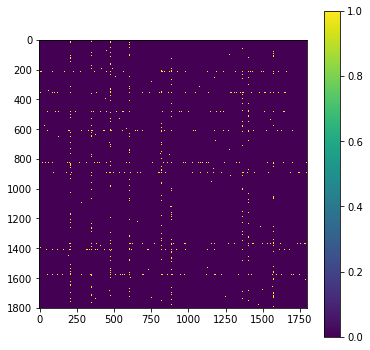

In [2]:
N = 1800                             # Number of nodes
num_classes = 2                      # Number of classes
p = torch.tensor([0.025, 0.975])     # Probability of each class
B = torch.tensor([                   # Connection probability between classes
        [0.66, 0.11],
        [0.11, 0.00053]])
delta = torch.tensor(
    [[0.,1.], [0.,1.]])
sbm = SBM(p, B)
z, A = sbm.generate(N)               # Generate the class assignments z and the adjacency matrix A
sbm.show(sorted=False)               # Show A

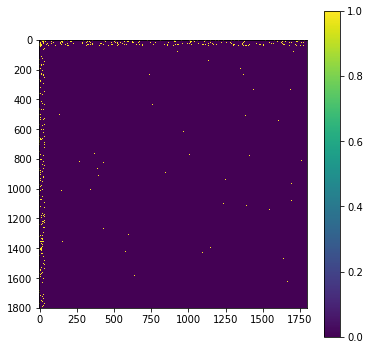

In [3]:
sbm.show(sorted=True)    # Show A sorted by class

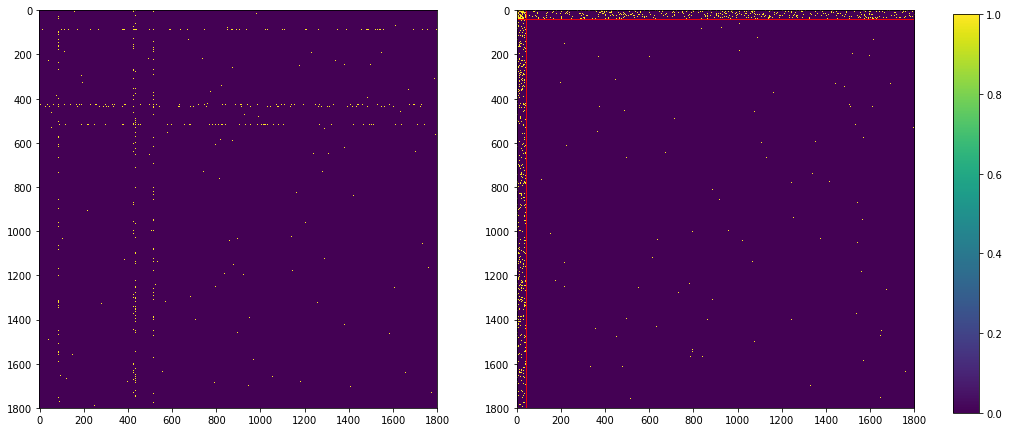

In [4]:
class_sizes = lambda classes: np.array(pd.Series(classes.numpy()).value_counts().sort_index())
cs = class_sizes(z.argmax(dim=1))
order = z.argmax(dim=1).argsort()
fig, axs = plt.subplots(1,2, figsize=(18,9))

axs[0].imshow(A.numpy(), cmap='viridis')
ax = axs[1].imshow(A[order,:][:,order].numpy(), cmap='viridis')
acc = -1
for i in cs[:-1]:
    acc += i
    axs[1].axvline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
    axs[1].axhline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.188, 0.02, 0.615])
fig.colorbar(ax, cax=cbar_ax, aspect=30)
#plt.savefig('../examples/images/ex3_A_sbm.pdf')
plt.show()

Next, we create a dataloader that transformes the adjacency matrix into a set of (start node, finish node, weight) tupels, fit the SBM to the generated data and show the summary.

In [5]:
delta_init = torch.ones([N,2])
delta_mu = (A.sum(dim=1)+1)/A.sum(dim=1).mean()
delta_init[:,0]=delta_mu.log().clone()
print('Contains infinities:', bool(torch.isinf(delta_init).sum().item()))

Contains infinities: False


In [6]:
dataloader = DataLoader(EdgesDataset(A), batch_size=int(N**2/128), shuffle=True, num_workers=0)
vi = VI_DCSBM(num_nodes=N, num_classes=num_classes,
             init_values={'etas':None, 
                          'thetas':None, 
                          'Bs':None, 
                          'deltas':delta_init})
vi.multi_train(dataloader, lrs=[0.1,0.05], epochs=[15,15], trials=10)
#vi.summary(A)

>>>>>>> Start multi-training...
>>> Trial 1/10 | Final loss: 65775.86 | Trial time 802.40
>>> Trial 2/10 | Final loss: 65857.32 | Trial time 791.05
>>> Trial 3/10 | Final loss: 65898.41 | Trial time 793.52
>>> Trial 4/10 | Final loss: 65883.23 | Trial time 816.83
>>> Trial 5/10 | Final loss: 65877.32 | Trial time 783.42
>>> Trial 6/10 | Final loss: 65842.55 | Trial time 794.79
>>> Trial 7/10 | Final loss: 65884.90 | Trial time 787.14
>>> Trial 8/10 | Final loss: 65864.95 | Trial time 785.52
>>> Trial 9/10 | Final loss: 65885.58 | Trial time 771.23
>>> Trial 10/10 | Final loss: 65877.20 | Trial time 809.38


In [7]:
best = vi.get_multi_losses()[:,-1].argsort()  

In [8]:
print('The lowest losses:', vi.get_multi_losses()[best,-1].numpy())

The lowest losses: [65775.86 65842.55 65857.32 65864.95 65877.2  65877.32 65883.23 65884.9
 65885.58 65898.41]


In [9]:
print('The number of classes in best trials:', 
      [len(vi.multi_results[0][i].argmax(dim=0).unique()) for i in best])

The number of classes in best trials: [1, 2, 1, 1, 1, 1, 2, 2, 2, 2]


In [33]:
vi.load_state_dict(vi.state_dicts[best[9]])
q_eta, q_theta, q_B, q_delta = vi.constrained_params()

In [34]:
permutation = [0,1]  # You may have to change the permutation
q_theta_perm = q_theta.detach()[permutation]
num_samples = 1000
theta_samples = Dirichlet(q_theta_perm).sample([num_samples])

In [35]:
import seaborn as sns
sns.set()

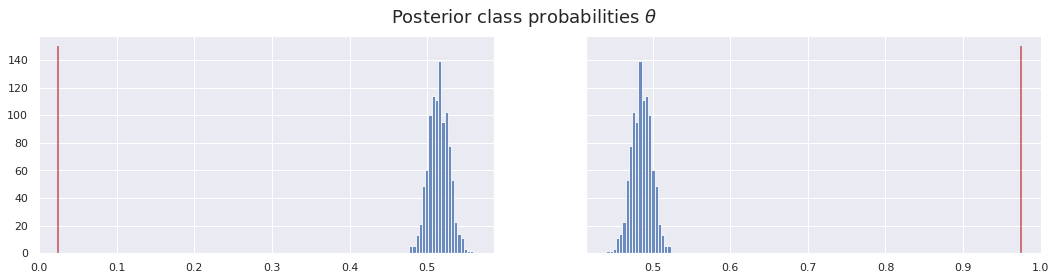

In [36]:
fig, axs = plt.subplots(1, num_classes, figsize=(18,4), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    axs[i].hist(theta_samples[:,i], bins=bins, alpha=alpha) 
    axs[i].vlines(p[i], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior class probabilities $\theta$', fontsize=18)
#plt.savefig('../examples/images/ex3_theta_sbm.pdf')
plt.show()

In [14]:
q_B_perm = q_B.detach()[permutation,:,:][:,permutation,:]
B_samples = Beta(q_B_perm[:,:,0], q_B_perm[:,:,1]).sample([num_samples])

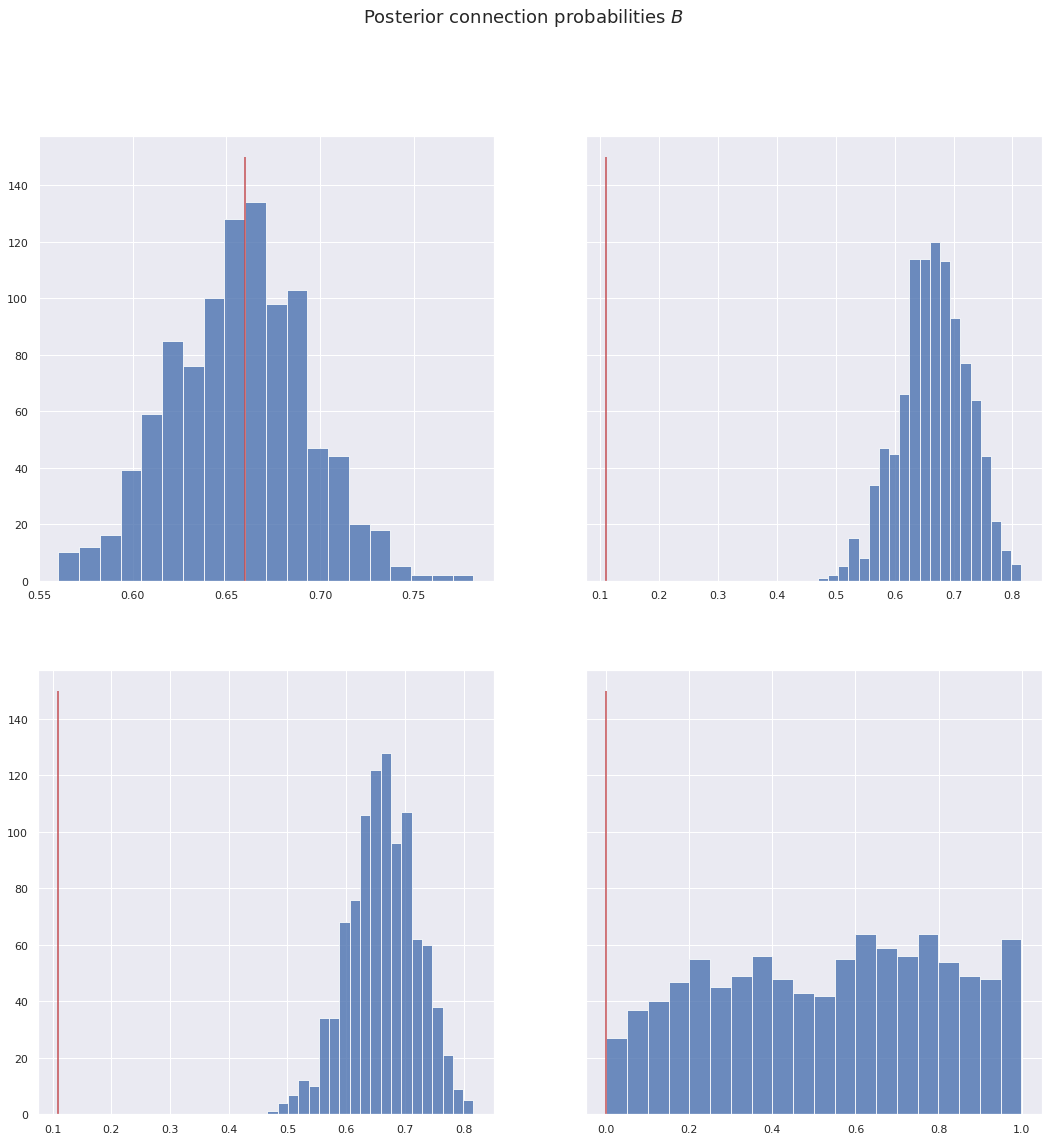

In [15]:
fig, axs = plt.subplots(num_classes, num_classes, figsize=(18,18), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
        axs[i,j].vlines(B[i,j], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
#plt.savefig('../examples/images/ex3_B_sbm.pdf')
plt.show()

In [16]:
vi.class_accuracy(z,q_eta)

tensor(0.9767)

In [37]:
for i in range(len(vi.multi_results[0])):
    print(vi.class_accuracy(z,vi.multi_results[0][i]).item())

0.9766666889190674
0.9766666889190674
0.745555579662323
0.9744444489479065
0.9766666889190674
0.9750000238418579
0.5255555510520935
0.9766666889190674
0.9555555582046509
0.9766666889190674
